In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pyro-ppl
!pip install pot
!pip install tensorboard
!pip install torchdiffeq
!pip install openml

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [4]:
!rm -rf PFNExperiments
!git clone https://github.com/ArikReuter/PFNExperiments


Cloning into 'PFNExperiments'...
remote: Enumerating objects: 1449, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 1449 (delta 151), reused 132 (delta 67), pack-reused 1227
Receiving objects: 100% (1449/1449), 60.23 MiB | 20.79 MiB/s, done.
Resolving deltas: 100% (1035/1035), done.


In [5]:
import torch
from PFNExperiments.LinearRegression.GenerativeModels.GenerateData import GenerateData, check_data, check_and_plot_data
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataLM_Examples import make_lm_program_ig_batched, make_lm_program_ig

from PFNExperiments.LinearRegression.GenerativeModels.GenerateX import simulate_X_uniform
from PFNExperiments.LinearRegression.GenerativeModels.LM_abstract import return_only_y, print_code
from PFNExperiments.LinearRegression.GenerativeModels.Quantizer import Quantizer
from PFNExperiments.LinearRegression.Models.Transformer_CNF import TransformerCNFConditionalDecoder
from PFNExperiments.Training.Trainer import Trainer, batch_to_model_lm, visualize_training_results
from PFNExperiments.Training.Losses import MSELoss_unsqueezed, nll_loss_full_gaussian
from PFNExperiments.Training.EvalMetrics import mean_squared_error_torch_avg, mae_torch_avg, r2_score_torch_avg
from PFNExperiments.LinearRegression.Models.ModelPosterior import ModelPosteriorFullGaussian, ModelPosteriorFullGaussian2
from PFNExperiments.LinearRegression.Models.AugmentLoss import add_l2_loss_nll_loss
from PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF_LearnedBaseDist import ModelToPosteriorCNF_LearnedBaseDist

from PFNExperiments.Training.FlowMatching.CFMLossOT2 import CFMLossOT2

from PFNExperiments.Evaluation.ComparePosteriorSamples import compare_all_metrics, marginal_plots_hist_parallel, marginal_plots_kde_together
from PFNExperiments.LinearRegression.Evaluation.CompareModels import ModelComparison
from PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF import ModelToPosteriorCNF
from PFNExperiments.LinearRegression.ComparisonModels.Hamiltionion_MC import Hamiltionian_MC

from PFNExperiments.LinearRegression.ComparisonModels.Variational_Inference import Variational_Inference, make_guide_program_gamma_gamma

from PFNExperiments.LinearRegression.Evaluation.CompareComparisonModels import CompareComparisonModels

from PFNExperiments.LinearRegression.GenerativeModels.Curriculum import Curriculum
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataCurriculumCFM import GenerateDataCurriculumCFM

from PFNExperiments.Training.TrainerCurriculumCNF import TrainerCurriculumCNF

from PFNExperiments.LinearRegression.ComparisonModels.AnalyticalSolutionsLM import PosteriorLM_IG
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataLM_Examples import make_lm_program_ig_batched, make_lm_program_ig
from PFNExperiments.LinearRegression.GenerativeModels.GenerateX import simulate_X_uniform

from PFNExperiments.LinearRegression.Evaluation.CompareComparisonModels import CompareComparisonModels

from PFNExperiments.Training.FlowMatching.Couplings import MiniBatchOTCoupling

from PFNExperiments.LinearRegression.ComparisonModels.Variational_InferenceAutoguide import Variational_InferenceAutoguide

from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoLaplaceApproximation, AutoIAFNormal, AutoStructured
from PFNExperiments.Evaluation.Evaluate import Evaluate

from PFNExperiments.Evaluation.RealWorldEvaluation.PreprocessDataset import Preprocessor
from PFNExperiments.Evaluation.RealWorldEvaluation.GetDataOpenML import GetDataOpenML

from PFNExperiments.Evaluation.RealWorldEvaluation.EvaluateRealWorld import EvaluateRealWorld, just_return_results, results_dict_to_latent_variable_beta, results_dict_to_latent_variable_beta0_and_beta

In [6]:
torch.backends.cudnn.benchmark = True

In [7]:
N = 50
P = 5
BATCH_SIZE = 1024
N_EPOCHS = 100
N_SAMPLES_PER_EPOCH = 500_000
N_BATCHES_PER_EPOCH = N_SAMPLES_PER_EPOCH//BATCH_SIZE
SAVE_PATH = "/content/drive/MyDrive/PFN_Experiments/Training_RunsCFM"
SAVE_PATH_EVALUATION = f"{SAVE_PATH}/PFN_Experiments_CFM_InverseGamma_v2_RealWorldEvaluation"

#BATCH_SIZE = 128

In [8]:
a = 5.0
b = 2.0
tau = 1.0

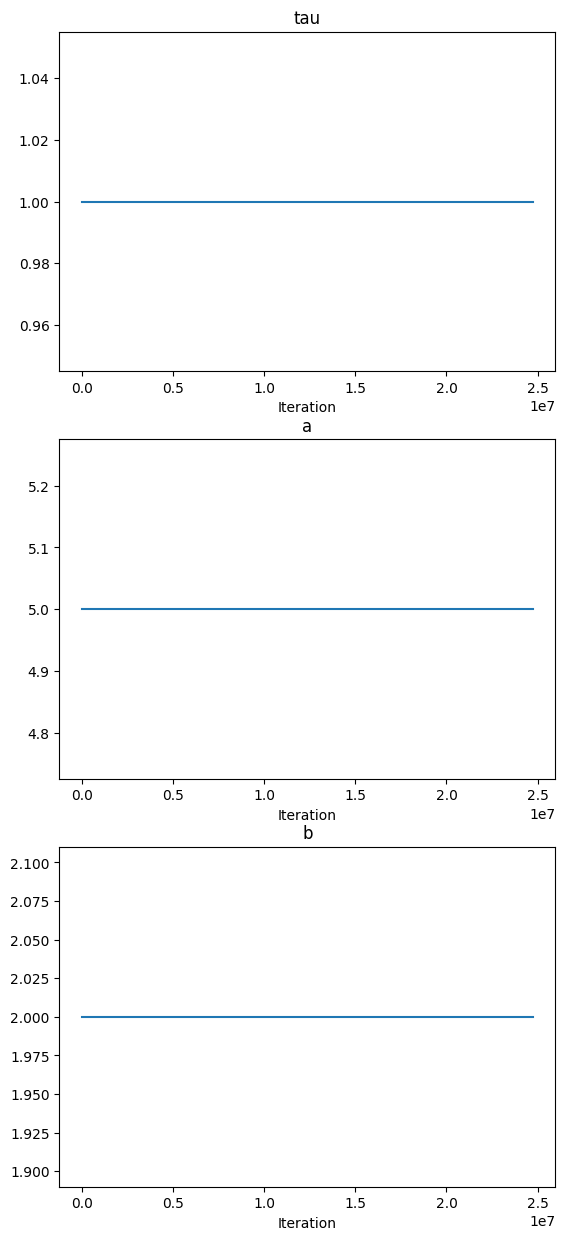

In [9]:
curriculum = Curriculum(max_iter=int(N_EPOCHS*N_BATCHES_PER_EPOCH*BATCH_SIZE*0.5))
curriculum.add_param_list(
    [
    ("tau", curriculum.constant_scheduler(tau)),
    ("a", curriculum.constant_scheduler(a)),
    ("b", curriculum.constant_scheduler(b)),

    ]
)
curriculum.plot_all_schedules()

In [10]:
curriculum.get_params(299*N_SAMPLES_PER_EPOCH)

{'tau': 1.0, 'a': 5.0, 'b': 2.0}

In [11]:
data_generator = GenerateDataCurriculumCFM(
    pprogram_maker= make_lm_program_ig_batched,
    curriculum= curriculum,
    #coupling = None
)

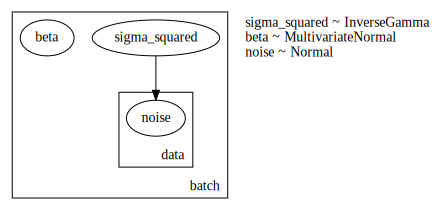

In [12]:
data_generator.render_model()

In [13]:
epoch_loader = data_generator.make_epoch_loader(
    n = N,
    p = P,
    number_of_batches_per_epoch = N_BATCHES_PER_EPOCH,
    n_epochs = N_EPOCHS,
    batch_size= BATCH_SIZE,
    train_frac= 0.5,
    val_frac= 0.1,
    shuffle=False,
    n_samples_to_generate_at_once = 250_000
)

The number of batches times the number of epochs must be equal to the total number of iterations in the curriculum. But got 49971200 and 24985600 respectively


In [14]:
#save_path_model = "/content/drive/MyDrive/PFN_Experiments/Training_Runs/experiment_2024_05_29_07_37_35/model.pth"

In [15]:

model = TransformerCNFConditionalDecoder(
    n_input_features_encoder = P+1,
    n_input_features_decoder = P,
    d_model_encoder = 512,
    d_model_decoder = 512,
    n_heads_encoder = 8,
    n_heads_decoder = 8,
    d_ff_encoder = 1024,
    d_ff_decoder = 1024,
    dropout_encoder = 0.1,
    dropout_decoder = 0.1,
    n_conditional_input_features =  1,
    n_condition_features = 512,
    n_layers_condition_embedding = 3,
    n_layers_encoder = 8,
    n_layers_decoder = 6,
    use_positional_encoding_encoder = True,
    use_positional_encoding_decoder = False,
    use_self_attention_decoder = False,
    output_dim = P,
    d_final_processing = 512,
    n_final_layers = 3,
    dropout_final = 0.1,
    treat_z_as_sequence = False,
)

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [17]:
'{:.2e}'.format(count_parameters(model))

'4.31e+07'

In [18]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

In [19]:
lr = 1e-4
opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)

In [20]:
loss_fun = CFMLossOT2(
    sigma_min=1e-2
)

In [21]:
scheduler = OneCycleLR(opt,
                       max_lr = 1e-4,
                       epochs = N_EPOCHS,
                       steps_per_epoch = N_SAMPLES_PER_EPOCH//BATCH_SIZE,
                       pct_start = 0.1,
                       div_factor=25.0,
                       final_div_factor=1e2)

#scheduler = ReduceLROnPlateau(opt)

additional_evals = {
}

In [22]:
#?TrainerCurriculumCNF

In [23]:
trainer = TrainerCurriculumCNF(
    model = model,
    optimizer=opt,
    scheduler = scheduler,
    loss_function=loss_fun,
    epoch_loader = epoch_loader,
    evaluation_functions= additional_evals,
    n_epochs = N_EPOCHS,
    early_stopping_patience = 200,
    schedule_step_on = "batch",
    save_path = SAVE_PATH,
    coupling = None,
    use_same_timestep_per_batch = False,
    use_train_mode_during_validation = False,
    max_gradient_norm = 1.0

)

In [24]:
trainer.set_new_save_path("/content/drive/MyDrive/PFN_Experiments/Training_RunsCFM/experiment_2024_08_06_10_25_00")

trainer.save_path

'/content/drive/MyDrive/PFN_Experiments/Training_RunsCFM/experiment_2024_08_06_10_25_00'

In [25]:
try:
  trainer.load_best_model()
except:
  print("Could not load model")
  pass

In [26]:
model.eval()
trainer.load_best_model()
trainer.model.cuda()

TransformerCNFConditionalDecoder(
  (condition_embedding_layer): MLP(
    (linear1): Linear_block(
      (fc): Linear(in_features=1, out_features=512, bias=True)
      (act): LeakyReLU(negative_slope=0.01)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop): Dropout(p=0.1, inplace=False)
    )
    (hidden_layers): Sequential(
      (0): Linear_skip_block(
        (fc): Linear(in_features=512, out_features=512, bias=True)
        (act): LeakyReLU(negative_slope=0.01)
        (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
      (1): Linear_skip_block(
        (fc): Linear(in_features=512, out_features=512, bias=True)
        (act): LeakyReLU(negative_slope=0.01)
        (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
      (2): Linear_skip_block(
    

In [27]:
trainer.test()

100%|██████████| 196/196 [01:19<00:00,  2.47it/s]


{'loss_mean': 0.3299914002418518,
 'loss_median': 0.32935628294944763,
 'loss_std': 0.015411128289997578}

In [28]:
N_SAMPLES_PER_MODEL = 1_000

In [29]:
full_model = ModelToPosteriorCNF(
    model = model.eval(),
    sample_name = "beta",
    sample_shape = (P,),
    n_samples=N_SAMPLES_PER_MODEL,
    batch_size = BATCH_SIZE,
    solve_adjoint = True,
    atol = 1e-7,
    rtol = 1e-7,
    #device = torch.device("cpu")
)
benchmark_params_ppgrogram = data_generator.curriculum.get_params(-1)
print(f"params for pprogram: {benchmark_params_ppgrogram}")

pprogram1 = make_lm_program_ig(**benchmark_params_ppgrogram)

pprogram1_y = return_only_y(pprogram1)
print_code(pprogram1)



benchmark_params_ppgrogram = data_generator.curriculum.get_params(-1)
print(f"params for pprogram: {benchmark_params_ppgrogram}")

pprogram1 = make_lm_program_ig(**benchmark_params_ppgrogram)

pprogram1_y = return_only_y(pprogram1)
print_code(pprogram1)






params for pprogram: {'tau': 1.0, 'a': 5.0, 'b': 2.0}
        def multivariate_lm_return_dict(x: torch.Tensor, y: torch.Tensor = None) -> dict:
                # Define distributions for the global parameters
                sigma_squared_dist = dist.InverseGamma(a, b)

                beta_cov = torch.eye(x.shape[1]) * (tau ** 2)  # the covariance matrix of the parameters of the linear model

                sigma_squared = pyro.sample("sigma_squared", sigma_squared_dist).squeeze()

                beta_dist = dist.MultivariateNormal(torch.zeros(x.shape[1]), beta_cov)
                beta = pyro.sample("beta", beta_dist)

                # Compute mean using matrix multiplication
                mean = torch.matmul(x, beta)

                with pyro.plate("data", len(x)):
                        y = pyro.sample("obs", pyro.distributions.Normal(mean, sigma_squared), obs=y)


                return {
                        "x": x,
                        "y": y,
                      

In [30]:
N_SAMPLES_PER_MODEL = 1000

In [31]:
analytical_solution = PosteriorLM_IG(
    pprogram_dict= {
        "tau": tau,
        "a": a,
        "b": b
    },
    n_samples=N_SAMPLES_PER_MODEL
)


hmc_sampler = Hamiltionian_MC(pprogram = pprogram1_y, n_warmup=500, n_samples=N_SAMPLES_PER_MODEL)

vi_diag = Variational_InferenceAutoguide(
    pprogram=pprogram1_y,
    make_guide_fun = AutoDiagonalNormal,
    n_steps = 2000,
    n_samples=N_SAMPLES_PER_MODEL,
    lr = 1e-2
)

vi_multivariate_normal = Variational_InferenceAutoguide(
    pprogram=pprogram1_y,
    make_guide_fun = AutoMultivariateNormal,
    n_steps = 2000,
    n_samples=N_SAMPLES_PER_MODEL,
    lr = 1e-2
)
vi_laplace = Variational_InferenceAutoguide(
    pprogram=pprogram1_y,
    make_guide_fun = AutoLaplaceApproximation,
    n_steps = 2000,
    n_samples=N_SAMPLES_PER_MODEL,
    lr = 1e-2
)

vi_autoIAF = Variational_InferenceAutoguide(
    pprogram=pprogram1_y,
    make_guide_fun=AutoIAFNormal,
    #additional_make_guide_args={"num_transforms": 5, "hidden_dim" : 100},
    n_steps = 2000,
    n_samples=N_SAMPLES_PER_MODEL,
    lr = 1e-3
)

vi_autostrucured = Variational_InferenceAutoguide(
    pprogram=pprogram1_y,
    make_guide_fun=AutoStructured,
    n_steps = 2000,
    n_samples=N_SAMPLES_PER_MODEL,
    lr = 1e-2
)


In [32]:

getdata = GetDataOpenML(
    preprocessor = Preprocessor(
        N_datapoints = N,
        P_features = P,
        target_mean = 0.0,
        target_var = 0.75
    ),
    save_path = "/content/drive/MyDrive/PFN_Experiments/DatasetsOpenML/numerical_regression.pkl",
    benchmark_id = 336
)
datasets = getdata.get_data()

An error occured while preprocessing the dataset with id 361086. Skipping the dataset


In [44]:
eval_rw = EvaluateRealWorld(
    posterior_model = full_model,
    evaluation_datasets = datasets,
    comparison_models = [
                        analytical_solution,
                        hmc_sampler,
                        vi_multivariate_normal,
                        vi_diag,
                        vi_laplace,
                        vi_autoIAF,
                        vi_autostrucured,
                        ],
    results_dict_to_latent_variable_comparison_models = just_return_results,
    n_evaluation_cases = len(datasets),
    save_path = SAVE_PATH_EVALUATION,
    overwrite_results = True
)

The save path is not empty and the overwrite flag is set, the results will be overwritten


In [45]:
eval_rw.run_evaluation()

Sampling posterior:   0%|          | 0/18 [00:00<?, ?it/s]
0it [00:00, ?it/s]
Sampling posterior:   6%|▌         | 1/18 [02:46<47:12, 166.61s/it]
0it [00:00, ?it/s]
Sampling posterior:  11%|█         | 2/18 [05:28<43:41, 163.83s/it]
0it [00:00, ?it/s]
Sampling posterior:  17%|█▋        | 3/18 [08:19<41:44, 167.00s/it]
0it [00:00, ?it/s]
Sampling posterior:  22%|██▏       | 4/18 [11:18<40:06, 171.88s/it]
0it [00:00, ?it/s]
Sampling posterior:  28%|██▊       | 5/18 [14:01<36:30, 168.54s/it]
0it [00:00, ?it/s]
Sampling posterior:  33%|███▎      | 6/18 [16:44<33:21, 166.81s/it]
0it [00:00, ?it/s]
Sampling posterior:  39%|███▉      | 7/18 [19:31<30:36, 166.97s/it]
0it [00:00, ?it/s]
Sampling posterior:  44%|████▍     | 8/18 [22:17<27:43, 166.36s/it]
0it [00:00, ?it/s]
Sampling posterior:  50%|█████     | 9/18 [24:56<24:37, 164.20s/it]
0it [00:00, ?it/s]
Sampling posterior:  56%|█████▌    | 10/18 [27:44<22:03, 165.49s/it]
0it [00:00, ?it/s]
Sampling posterior:  61%|██████    | 11/18 [30:38<1

....................


Sampling posterior:   6%|▌         | 1/18 [00:13<03:43, 13.14s/it]

....................


Sampling posterior:  11%|█         | 2/18 [00:26<03:29, 13.11s/it]

....................


Sampling posterior:  17%|█▋        | 3/18 [00:39<03:18, 13.25s/it]

....................


Sampling posterior:  22%|██▏       | 4/18 [00:52<03:05, 13.24s/it]

....................


Sampling posterior:  28%|██▊       | 5/18 [01:06<02:52, 13.28s/it]

....................


Sampling posterior:  33%|███▎      | 6/18 [01:19<02:39, 13.33s/it]

....................


Sampling posterior:  39%|███▉      | 7/18 [01:32<02:26, 13.28s/it]

....................


Sampling posterior:  44%|████▍     | 8/18 [01:45<02:12, 13.24s/it]

....................


Sampling posterior:  50%|█████     | 9/18 [01:59<01:59, 13.32s/it]

....................


Sampling posterior:  56%|█████▌    | 10/18 [02:12<01:46, 13.34s/it]

....................


Sampling posterior:  61%|██████    | 11/18 [02:26<01:33, 13.33s/it]

....................


Sampling posterior:  67%|██████▋   | 12/18 [02:39<01:20, 13.37s/it]

....................


Sampling posterior:  72%|███████▏  | 13/18 [02:53<01:07, 13.52s/it]

....................


Sampling posterior:  78%|███████▊  | 14/18 [03:06<00:53, 13.50s/it]

....................


Sampling posterior:  83%|████████▎ | 15/18 [03:20<00:40, 13.40s/it]

....................


Sampling posterior:  89%|████████▉ | 16/18 [03:33<00:26, 13.47s/it]

....................


Sampling posterior:  94%|█████████▍| 17/18 [03:47<00:13, 13.45s/it]

....................


Sampling posterior:   0%|          | 0/18 [00:00<?, ?it/s]

....................


Sampling posterior:   6%|▌         | 1/18 [00:11<03:17, 11.63s/it]

....................


Sampling posterior:  11%|█         | 2/18 [00:23<03:03, 11.48s/it]

....................


Sampling posterior:  17%|█▋        | 3/18 [00:34<02:51, 11.42s/it]

....................


Sampling posterior:  22%|██▏       | 4/18 [00:45<02:39, 11.40s/it]

....................


Sampling posterior:  28%|██▊       | 5/18 [00:57<02:30, 11.55s/it]

....................


Sampling posterior:  33%|███▎      | 6/18 [01:08<02:17, 11.47s/it]

....................


Sampling posterior:  39%|███▉      | 7/18 [01:20<02:06, 11.46s/it]

....................


Sampling posterior:  44%|████▍     | 8/18 [01:31<01:54, 11.44s/it]

....................


Sampling posterior:  50%|█████     | 9/18 [01:43<01:43, 11.49s/it]

....................


Sampling posterior:  56%|█████▌    | 10/18 [01:54<01:31, 11.47s/it]

....................


Sampling posterior:  61%|██████    | 11/18 [02:06<01:20, 11.45s/it]

....................


Sampling posterior:  67%|██████▋   | 12/18 [02:17<01:08, 11.42s/it]

....................


Sampling posterior:  72%|███████▏  | 13/18 [02:29<00:57, 11.49s/it]

....................


Sampling posterior:  78%|███████▊  | 14/18 [02:40<00:45, 11.46s/it]

....................


Sampling posterior:  83%|████████▎ | 15/18 [02:51<00:34, 11.46s/it]

....................


Sampling posterior:  89%|████████▉ | 16/18 [03:03<00:23, 11.54s/it]

....................


Sampling posterior:  94%|█████████▍| 17/18 [03:15<00:11, 11.49s/it]

....................


Sampling posterior:   0%|          | 0/18 [00:00<?, ?it/s]

....................


Sampling posterior:   6%|▌         | 1/18 [00:10<02:51, 10.08s/it]

....................


Sampling posterior:  11%|█         | 2/18 [00:20<02:40, 10.04s/it]

....................


Sampling posterior:  17%|█▋        | 3/18 [00:30<02:32, 10.17s/it]

....................


Sampling posterior:  22%|██▏       | 4/18 [00:40<02:20, 10.05s/it]

....................


Sampling posterior:  28%|██▊       | 5/18 [00:50<02:10, 10.01s/it]

....................


Sampling posterior:  33%|███▎      | 6/18 [01:00<02:00, 10.00s/it]

....................


Sampling posterior:  39%|███▉      | 7/18 [01:10<01:50, 10.08s/it]

....................


Sampling posterior:  44%|████▍     | 8/18 [01:20<01:40, 10.05s/it]

....................


Sampling posterior:  50%|█████     | 9/18 [01:30<01:30, 10.06s/it]

....................


Sampling posterior:  56%|█████▌    | 10/18 [01:40<01:20, 10.12s/it]

....................


Sampling posterior:  61%|██████    | 11/18 [01:50<01:10, 10.13s/it]

....................


Sampling posterior:  67%|██████▋   | 12/18 [02:01<01:00, 10.12s/it]

....................


Sampling posterior:  72%|███████▏  | 13/18 [02:11<00:50, 10.09s/it]

....................


Sampling posterior:  78%|███████▊  | 14/18 [02:21<00:40, 10.05s/it]

....................


Sampling posterior:  83%|████████▎ | 15/18 [02:31<00:30, 10.10s/it]

....................


Sampling posterior:  89%|████████▉ | 16/18 [02:41<00:20, 10.09s/it]

....................


Sampling posterior:  94%|█████████▍| 17/18 [02:51<00:10, 10.06s/it]

....................


Sampling posterior:   0%|          | 0/18 [00:00<?, ?it/s]

....................


Sampling posterior:   6%|▌         | 1/18 [00:14<04:12, 14.85s/it]

....................


Sampling posterior:  11%|█         | 2/18 [00:29<03:56, 14.78s/it]

....................


Sampling posterior:  17%|█▋        | 3/18 [00:44<03:43, 14.87s/it]

....................


Sampling posterior:  22%|██▏       | 4/18 [00:59<03:26, 14.78s/it]

....................


Sampling posterior:  28%|██▊       | 5/18 [01:13<03:11, 14.74s/it]

....................


Sampling posterior:  33%|███▎      | 6/18 [01:28<02:58, 14.86s/it]

....................


Sampling posterior:  39%|███▉      | 7/18 [01:43<02:43, 14.83s/it]

....................


Sampling posterior:  44%|████▍     | 8/18 [01:58<02:28, 14.82s/it]

....................


Sampling posterior:  50%|█████     | 9/18 [02:13<02:14, 14.90s/it]

....................


Sampling posterior:  56%|█████▌    | 10/18 [02:28<01:58, 14.83s/it]

....................


Sampling posterior:  61%|██████    | 11/18 [02:42<01:43, 14.78s/it]

....................


Sampling posterior:  67%|██████▋   | 12/18 [02:57<01:28, 14.83s/it]

....................


Sampling posterior:  72%|███████▏  | 13/18 [03:12<01:13, 14.80s/it]

....................


Sampling posterior:  78%|███████▊  | 14/18 [03:27<00:59, 14.85s/it]

....................


Sampling posterior:  83%|████████▎ | 15/18 [03:42<00:44, 14.81s/it]

....................


Sampling posterior:  89%|████████▉ | 16/18 [03:56<00:29, 14.74s/it]

....................


Sampling posterior:  94%|█████████▍| 17/18 [04:11<00:14, 14.84s/it]

....................


Sampling posterior:   0%|          | 0/18 [00:00<?, ?it/s]

....................


Sampling posterior:   6%|▌         | 1/18 [00:18<05:06, 18.03s/it]

....................


Sampling posterior:  11%|█         | 2/18 [00:35<04:40, 17.53s/it]

....................


Sampling posterior:  17%|█▋        | 3/18 [00:52<04:22, 17.49s/it]

....................


Sampling posterior:  22%|██▏       | 4/18 [01:10<04:04, 17.45s/it]

....................


Sampling posterior:  28%|██▊       | 5/18 [01:27<03:47, 17.48s/it]

....................


Sampling posterior:  33%|███▎      | 6/18 [01:44<03:28, 17.37s/it]

....................


Sampling posterior:  39%|███▉      | 7/18 [02:02<03:11, 17.38s/it]

....................


Sampling posterior:  44%|████▍     | 8/18 [02:19<02:54, 17.43s/it]

....................


Sampling posterior:  50%|█████     | 9/18 [02:36<02:36, 17.39s/it]

....................


Sampling posterior:  56%|█████▌    | 10/18 [02:54<02:19, 17.45s/it]

....................


Sampling posterior:  61%|██████    | 11/18 [03:11<02:01, 17.39s/it]

....................


Sampling posterior:  67%|██████▋   | 12/18 [03:29<01:44, 17.44s/it]

....................


Sampling posterior:  72%|███████▏  | 13/18 [03:46<01:26, 17.34s/it]

....................


Sampling posterior:  78%|███████▊  | 14/18 [04:04<01:09, 17.41s/it]

....................


Sampling posterior:  83%|████████▎ | 15/18 [04:21<00:52, 17.40s/it]

....................


Sampling posterior:  89%|████████▉ | 16/18 [04:39<00:35, 17.54s/it]

....................


Sampling posterior:  94%|█████████▍| 17/18 [04:56<00:17, 17.56s/it]

....................


Sampling posterior: 100%|██████████| 18/18 [05:14<00:00, 17.47s/it]


Comparison to ground truth:

Summarized results:

Comparison among models:

Summarized results:


,Model 1,Model 2,Mean_Wasserstein_distance with metric euclidean,Mean_MMD,Mean_cst_roc_auc,Std_Wasserstein_distance with metric euclidean,Std_MMD,Std_cst_roc_auc
0,<PFNExperiments.LinearRegression.Models.ModelT...,<PFNExperiments.LinearRegression.ComparisonMod...,0.726362,0.214548,0.662111,0.323833,0.193121,0.075890
1,<PFNExperiments.LinearRegression.Models.ModelT...,Hamiltonian Monte Carlo,0.621823,0.099469,0.603556,0.336189,0.166703,0.081109
2,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: AutoMultivar...,0.677326,0.140368,0.654722,0.325125,0.158126,0.070196
3,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: AutoDiagonal...,0.974427,0.507213,0.870000,0.323850,0.383752,0.072873
4,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: AutoLaplaceA...,1.619765,2.091291,1.000000,0.398484,0.254430,0.000000
5,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: AutoIAFNorma...,0.795555,0.227506,0.698222,0.320635,0.180646,0.063282
6,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: AutoStructur...,0.662782,0.130324,0.627889,0.356124,0.184408,0.081365
7,<PFNExperiments.LinearRegression.ComparisonMod...,Hamiltonian Monte Carlo,0.531794,0.092662,0.584944,0.143393,0.076883,0.046382
8,<PFNExperiments.LinearRegression.ComparisonMod...,Variational Inference with guide: AutoMultivar...,0.504629,0.075988,0.598056,0.136270,0.058256,0.045646
9,<PFNExperiments.LinearRegression.ComparisonMod...,Variational Inference with guide: AutoDiagonal...,0.704769,0.335560,0.820028,0.212172,0.325294,0.115890


P-values:


,Pair 1: Model A,Pair 1: Model B,Pair 2: Model A,Pair 2: Model B,Wasserstein_distance with metric euclidean_p-value,MMD_p-value,cst_roc_auc_p-value
0,<PFNExperiments.LinearRegression.Models.ModelT...,<PFNExperiments.LinearRegression.ComparisonMod...,<PFNExperiments.LinearRegression.Models.ModelT...,Hamiltonian Monte Carlo,1.412384e-01,4.191808e-04,5.360120e-03
1,<PFNExperiments.LinearRegression.Models.ModelT...,<PFNExperiments.LinearRegression.ComparisonMod...,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: AutoMultivar...,6.016446e-01,4.128168e-02,9.369559e-01
2,<PFNExperiments.LinearRegression.Models.ModelT...,<PFNExperiments.LinearRegression.ComparisonMod...,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: AutoDiagonal...,2.788626e-02,3.427218e-03,2.242158e-06
3,<PFNExperiments.LinearRegression.Models.ModelT...,<PFNExperiments.LinearRegression.ComparisonMod...,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: AutoLaplaceA...,3.568428e-06,3.227837e-07,4.720625e-08
4,<PFNExperiments.LinearRegression.Models.ModelT...,<PFNExperiments.LinearRegression.ComparisonMod...,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: AutoIAFNorma...,5.166026e-01,4.382536e-01,9.988344e-02
...,...,...,...,...,...,...,...
163,Variational Inference with guide: AutoDiagonal...,Variational Inference with guide: AutoStructur...,Variational Inference with guide: AutoLaplaceA...,Variational Inference with guide: AutoStructur...,3.060854e-06,3.227837e-07,4.720625e-08
164,Variational Inference with guide: AutoDiagonal...,Variational Inference with guide: AutoStructur...,Variational Inference with guide: AutoIAFNorma...,Variational Inference with guide: AutoStructur...,1.412384e-01,1.412384e-01,1.375954e-04
165,Variational Inference with guide: AutoLaplaceA...,Variational Inference with guide: AutoIAFNorma...,Variational Inference with guide: AutoLaplaceA...,Variational Inference with guide: AutoStructur...,7.397342e-01,1.474381e-03,1.000000e+00
166,Variational Inference with guide: AutoLaplaceA...,Variational Inference with guide: AutoIAFNorma...,Variational Inference with guide: AutoIAFNorma...,Variational Inference with guide: AutoStructur...,6.258023e-07,3.227837e-07,4.720625e-08


{'summarized_results': {'model_comparison_among_each_other':                                               Model 1  \
  0   <PFNExperiments.LinearRegression.Models.ModelT...   
  1   <PFNExperiments.LinearRegression.Models.ModelT...   
  2   <PFNExperiments.LinearRegression.Models.ModelT...   
  3   <PFNExperiments.LinearRegression.Models.ModelT...   
  4   <PFNExperiments.LinearRegression.Models.ModelT...   
  5   <PFNExperiments.LinearRegression.Models.ModelT...   
  6   <PFNExperiments.LinearRegression.Models.ModelT...   
  7   <PFNExperiments.LinearRegression.ComparisonMod...   
  8   <PFNExperiments.LinearRegression.ComparisonMod...   
  9   <PFNExperiments.LinearRegression.ComparisonMod...   
  10  <PFNExperiments.LinearRegression.ComparisonMod...   
  11  <PFNExperiments.LinearRegression.ComparisonMod...   
  12  <PFNExperiments.LinearRegression.ComparisonMod...   
  13                            Hamiltonian Monte Carlo   
  14                            Hamiltonian Monte Carlo 

In [ ]:
eval_rw.plot_results(max_number_plots=20)